In [22]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy , copy

In [2]:
dn

NameError: name 'dn' is not defined

# Exact (Qutip)

In [13]:
# System initialization
t = 2
u = 0.1
mu = 0.5
Lx = 4
Ly = 4
n_bosons = 2
system = ptn.BoseHubbard2D_Qutip(Lx, Ly, n_bosons, t, u, mu)

# Create initial state
black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")
# psi0 = system.uniform_product_state([1/np.sqrt(2), 1/np.sqrt(2)])
# Evolve system
end_time = 1
dt = 0.01
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


# 2TDVP on MPS (TenPy)

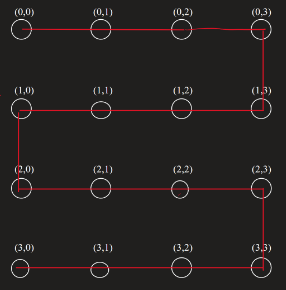

In [ ]:
# Set up parameters
Lx = 4
Ly = 4
n_bosons = 2
t = 2
U = 0.1
mu = 0.5

# Create model and initial state
model = ptn.BoseHubbard2D_Tenpy(Lx, Ly, n_bosons, t, U, mu)
black_state = [0, 1]  # |0>
white_state = [1, 0]  # |1>
mps = model.alternating_product_state_custom(black_state, white_state, pattern="checkerboard")

# Print initial state energy
print("Initial energy:", model.H_MPO.expectation_value(mps))

# Print initial occupation for a few sites
print("Initial occupations:")
occ_initial = model.calculate_occupation(mps)
print(occ_initial)  # Print first 2x2 corner

# Evolution parameters
lanczos_params = {
    'N_min': 2,           # Min number of Lanczos steps per /5
    'N_max': 20,          # Max number of Lanczos steps per evolution step/20
    'P_tol': 1e-6,       # Tolerance for convergence in Lanczos /1e-14
    'reortho': False}     # Reorthogonalize vectors in the Krylov space /False
   

# Evolve the state
psi_evolved = model.evolve_system_two_site(mps, 
                                           end_time = 2,
                                           dt = 0.01, 
                                           chi_max = 80, 
                                           svd_min = 1e-3, 
                                           lanczos_params=lanczos_params) 

# TDVP 

# Spanning Tree

# Initialize state

In [7]:
local_state = np.array([0,1])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 5)

black_state = np.array([0,1])
white_state = np.array([1,0])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = 2,  pattern = "checkerboard")

In [9]:
t = 2
u = 0.1
m = 0.5
Lx = 4
Ly = 4

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, 2)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

Correlation_function = ptn.Correlation_function("Site(0,0)", "Site(2,0)", 2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

occupation_22 = ptn.Number_op_local("Site(2,2)", 2)
occupation_22 = occupation_22.pad_with_identities(ttn, symbolic= True)
occupation_22 = ptn.TTNO.from_hamiltonian(occupation_22, ttn)

I = ptn.TTNO.Identity(ttn)


In [10]:
lanczos_params =  {'N_min': 2,   
                   'N_max': 20,           
                   'P_tol': 1e-8,          
                   'reortho': True,}

expansion_params = {"ExpansionMode": ptn.ExpansionMode.TTN,
                    "KrylovBasisMode": ptn.KrylovBasisMode.apply_1st_order_expansion,
                    "num_vecs": 3, 
                    "tau": 0.1,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                    "expansion_steps" : 10,
                    "tol": 0.01,
                    "tol_step_increase": 0.03,
                    "tol_step_decrease": 0.005,
                    "num_second_trial" : 10,
                    "max_bond": 240,
                    "rel_tot_bond": (5,20),
                    "T3N_dict" : {"Site(0,1)" : "Site(0,2)",
                                  "Site(0,2)" : "Site(0,3)",
                                  "Site(2,0)" : "Site(3,0)",
                                  "Site(3,2)" : "Site(3,3)"}}

config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   Lanczos_evolution = False,
                                   Lanczos_params = lanczos_params,
                                   Expansion_params = expansion_params)

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 1,
                                 operators = [Correlation_function , occupation_22],
                                 config = config)

In [ ]:
tdvp = ptn.SecondOrderTwoSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 1,
                                 operators = [Correlation_function , occupation_22],
                                 truncation_parameters= ptn.SVDParameters(max_bond_dim = 20 , rel_tol= 0.001 , total_tol = -np.inf),
                                 config = config)
tdvp.run(2)

In [11]:
tdvp.RUN(evaluation_time = 2)
times = tdvp.times()

  0%|          | 0/101 [00:00<?, ?it/s]

 10%|▉         | 10/101 [00:00<00:06, 14.57it/s]

SVD MAX: 5
Initial tol: 0.01
Phase 1 - Trial 1:
Expanded dim (57) > rel_tot_bond ((5, 20))
Increasing tol: 0.04
Phase 1 - Trial 2:
Expanded dim (62) > rel_tot_bond ((5, 20))
Increasing tol: 0.07
Phase 1 - Trial 3:
Expanded dim (32) > rel_tot_bond ((5, 20))
Increasing tol: 0.1
Acceptable expansion found in Phase 1: 20
Final expanded_dim: 20 : 75 ---> 95


 21%|██        | 21/101 [00:07<00:42,  1.90it/s]

SVD MAX: 18
Initial tol: 0.1
Phase 1 - Trial 1:
Expanded dim (41) > rel_tot_bond ((5, 20))
Increasing tol: 0.13
Phase 1 - Trial 2:
Expanded dim (31) > rel_tot_bond ((5, 20))
Increasing tol: 0.16
Phase 1 - Trial 3:
Expanded dim (31) > rel_tot_bond ((5, 20))
Increasing tol: 0.19
Phase 1 - Trial 4:
Expanded dim (27) > rel_tot_bond ((5, 20))
Increasing tol: 0.22
Phase 1 - Trial 5:
Expanded dim (43) > rel_tot_bond ((5, 20))
Increasing tol: 0.25
Phase 1 - Trial 6:
Expanded dim (21) > rel_tot_bond ((5, 20))
Increasing tol: 0.28
Phase 1 - Trial 7:
Expanded dim (34) > rel_tot_bond ((5, 20))
Increasing tol: 0.31000000000000005
Phase 1 - Trial 8:
Expanded dim (35) > rel_tot_bond ((5, 20))
Increasing tol: 0.3400000000000001
Phase 1 - Trial 9:
Expanded dim (42) > rel_tot_bond ((5, 20))
Increasing tol: 0.3700000000000001
Phase 1 - Trial 10:
Expanded dim (37) > rel_tot_bond ((5, 20))
Increasing tol: 0.40000000000000013


 22%|██▏       | 22/101 [00:15<03:40,  2.80s/it]

Acceptable expansion found in Phase 1: 18
Final expanded_dim: 18 : 95 ---> 113


 32%|███▏      | 32/101 [00:45<04:10,  3.63s/it]

SVD MAX: 27
Initial tol: 0.40000000000000013


 33%|███▎      | 33/101 [00:50<04:36,  4.07s/it]

Acceptable expansion found in initial attempt: 11
Final expanded_dim: 11 : 113 ---> 124


 43%|████▎     | 43/101 [01:25<03:19,  3.43s/it]

SVD MAX: 21
Initial tol: 0.40000000000000013
Phase 1 - Trial 1:
Expanded dim (27) > rel_tot_bond ((5, 20))
Increasing tol: 0.43000000000000016
Phase 1 - Trial 2:
Expanded dim (34) > rel_tot_bond ((5, 20))
Increasing tol: 0.4600000000000002
Phase 1 - Trial 3:
Expanded dim (35) > rel_tot_bond ((5, 20))
Increasing tol: 0.4900000000000002


 44%|████▎     | 44/101 [01:33<04:40,  4.92s/it]

Acceptable expansion found in Phase 1: 17
Final expanded_dim: 17 : 124 ---> 141


 53%|█████▎    | 54/101 [03:15<07:37,  9.74s/it]

SVD MAX: 24
Initial tol: 0.4900000000000002


 54%|█████▍    | 55/101 [03:26<07:49, 10.20s/it]

Acceptable expansion found in initial attempt: 11
Final expanded_dim: 11 : 141 ---> 152


 64%|██████▍   | 65/101 [04:43<04:41,  7.81s/it]

SVD MAX: 27
Initial tol: 0.4900000000000002
Phase 1 - Trial 1:
Expanded dim (21) > rel_tot_bond ((5, 20))
Increasing tol: 0.5200000000000002


 65%|██████▌   | 66/101 [04:58<05:51, 10.03s/it]

Acceptable expansion found in Phase 1: 8
Final expanded_dim: 8 : 152 ---> 160


 75%|███████▌  | 76/101 [06:49<04:26, 10.67s/it]

SVD MAX: 32
Initial tol: 0.5200000000000002
Phase 1 - Trial 1:
Expanded dim (22) > rel_tot_bond ((5, 20))
Increasing tol: 0.5500000000000003


 76%|███████▌  | 77/101 [07:04<04:52, 12.17s/it]

Acceptable expansion found in Phase 1: 19
Final expanded_dim: 19 : 160 ---> 179


 86%|████████▌ | 87/101 [09:50<03:52, 16.58s/it]

SVD MAX: 36
Initial tol: 0.5500000000000003


 87%|████████▋ | 88/101 [10:11<03:51, 17.80s/it]

Acceptable expansion found in initial attempt: 16
Final expanded_dim: 16 : 179 ---> 195


 97%|█████████▋| 98/101 [13:37<00:59, 19.67s/it]

SVD MAX: 40
Initial tol: 0.5500000000000003


 98%|█████████▊| 99/101 [14:00<00:41, 20.52s/it]

Acceptable expansion found in initial attempt: 15
Final expanded_dim: 15 : 195 ---> 210


100%|██████████| 101/101 [15:08<00:00,  8.99s/it]


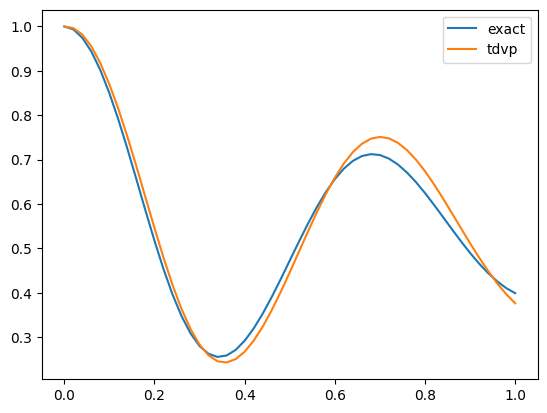

In [19]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)

plt.plot(times, oc_exact[:,2,2]  , label="exact")

plt.plot(times ,tdvp.operator_results()[1], label="tdvp")

plt.legend()
plt.show()

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


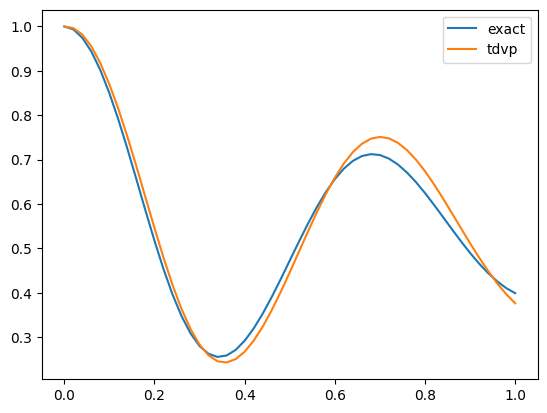

In [14]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)

plt.plot(times, oc_exact[:,2,2]  , label="exact")

plt.plot(times ,tdvp.operator_results()[1], label="tdvp")

plt.legend()
plt.show()

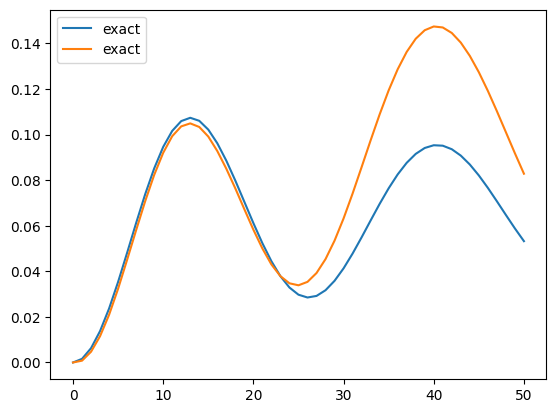

In [20]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)

plt.plot(correlation_exact, label="exact")
plt.plot(tdvp.operator_results()[0], label="exact")
plt.legend()

C:\Users\edpou\AppData\Local\Temp\ipykernel_20008\575452628.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


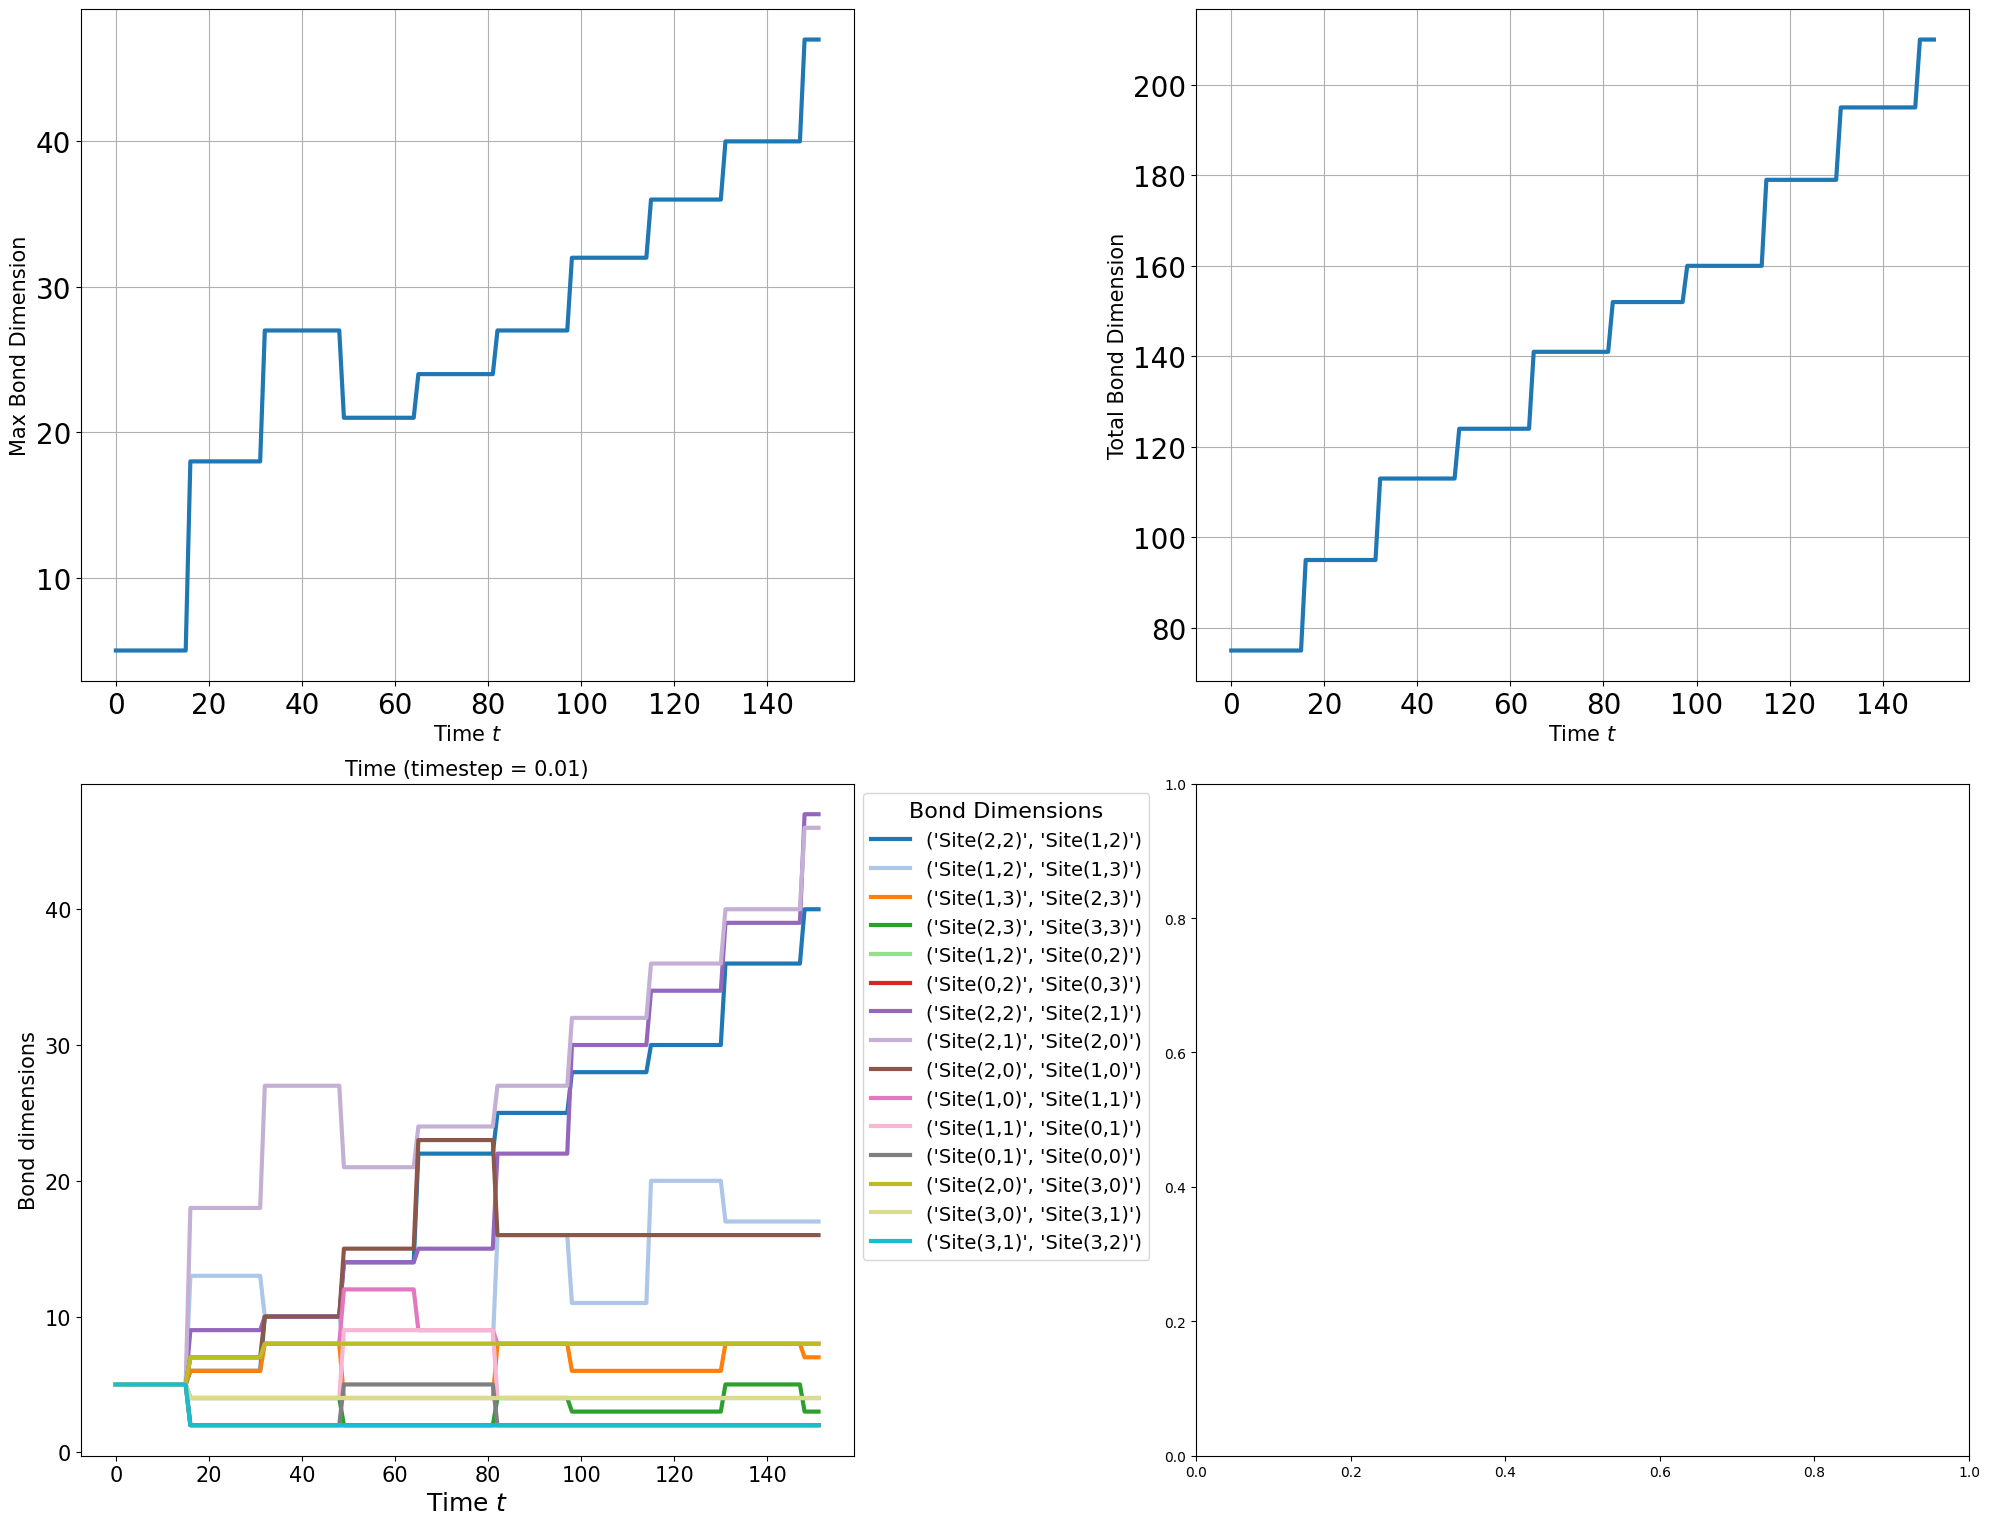

In [17]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot max bond dimension
axs[0, 0].plot(tdvp.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp.bond_dims))
for i, (key, values) in enumerate(tdvp.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


In [ ]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
oc_exact_00 = oc_exact[:,2,2]
oc_tenpy, times = model.occupation_results(psi_list= psi_evolved, evaluation_time=2, dt = 0.01)
oc_tenpy = oc_tenpy[:,2,2]
oc_tdvp = tdvp.operator_results()[1]

plt.plot(times, abs(oc_tdvp - oc_exact_00) / oc_exact_00 , label="1tdvp - 2 min")
plt.plot(times, abs(oc_tenpy - oc_exact_00) / oc_exact_00 , label="tenpy - 5 min")
#plt.plot(times, oc_exact_00, label="exact")

plt.title("(0,0) occupation error")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()

In [ ]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)


plt.plot(times, abs(tdvp.operator_results()[0]), label="1tdvp - 2 min")
#plt.plot(times, correlation_tenpy, label="tenpy - 5 min")
plt.plot(times, correlation_exact, label="exact")

plt.title("(0,0)-(2,0) Correlation")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()